In [1]:
globalseed = 1

All galaxies with mass below this value will be excluded.

In [2]:
masscut = 10**9

# Basic settings

### Settings that define the different runs

Each cell contains one run settings. These should all be coded as "Raw NBConvert" cells. The wrapper function will pull out the appropriate settings and run the full notebook, and finally save the output as a separate Jupyter notebook.

`PredsFullModel` holds all of the predictors that are used in the model with both observable and unobservable features. (This was called `PredsFullTest` in previous versions.)

In [3]:
runname = "ComparisonModel"

PredsFullModel = ['log galaxy_mass','log sigma_v',
            'log SubhaloSFR', 'SubhaloSFRZero','mc_disk',
            'log delta3d_smooth_real_0.5', 'log delta3d_smooth_real_1.0',
            'log delta3d_smooth_real_2.0','log delta3d_smooth_real_5.0',
            'rband Mag','gband Mag','iband Mag','zband Mag','delta_smooth_R']

ObsPredsUse = ['rband Mag','gband Mag','iband Mag','zband Mag','delta_smooth_R','mc_disk']

FullModelRespUse = 'log size'

predsscl = ['rband Mag','gband Mag','iband Mag','zband Mag','log SubhaloSFR','log sigma_v','log galaxy_mass','mc_disk',
            'log delta3d_smooth_real_0.5', 'log delta3d_smooth_real_1.0',
            'log delta3d_smooth_real_2.0','log delta3d_smooth_real_5.0','delta_smooth_R']

In [4]:
file_dir='./temp/ChadAnalyses/'+runname+'/'

This is the end of settings cells.

### Settings that are fixed across runs

In [5]:
traintestseed = globalseed

# Import Packages

In [6]:
%pylab inline

import illustris_python as il
import pandas as pd
import pickle

import os

from astropy.table import Table

from matplotlib.colors import LogNorm

import random

from skpp import ProjectionPursuitRegressor

Populating the interactive namespace from numpy and matplotlib


This is a suite of code that runs the projection pursuit regression.

In [7]:
%run ./FullPPR.ipynb

In [8]:
np.random.seed(globalseed)

In [9]:
basePath= '/hildafs/datasets/IllustrisTNG/TNG100-1/output'
snapNum=99 #refers to final snapshot, redshift of zero

# Create the combined catalog

Start with data from the base Illustris catalog.

See https://www.tng-project.org/data/docs/specifications/#sec2b

These are the fields that will be extracted from this catalog.

In [10]:
addvariables = ['SubhaloBHMass','SubhaloGasMetallicity','SubhaloSFR',
                'SubhaloStarMetallicity','SubhaloVmax']

In [11]:
fields = ['SubhaloGrNr',
          'SubhaloFlag',
          'SubhaloMassType',
          'SubhaloPos',
          'SubhaloStellarPhotometrics',
          'SubhaloMassInHalfRad',
          'SubhaloHalfmassRad',
          'SubhaloHalfmassRadType'] + addvariables

In [12]:
subhalos=il.groupcat.loadSubhalos(basePath,snapNum,fields=fields)

This is here just for reference:

0. PartType0 - GAS
1. PartType1 - DM
2. PartType2 - (unused)
3. PartType3 - TRACERS
4. PartType4 - STARS & WIND PARTICLES
5. PartType5 - BLACK HOLES

### Read in additional catalogs

THIS SEEMS TO BE UNNECESSARY. EVERYTHING IN HERE APPEARS TO BE IN THE FULL CATALOG BELOW.
The shape catalog. Note that this catalog already comes in with a mass cut of `10**10 M_sun`.

In [13]:
#df_non_red_100_subfind_shapes = pd.DataFrame(
#    pickle.load(open('/hildafs/datasets/IllustrisTNG/TNG100-1/df_non_red_100_subfind_mass-cut10', "rb" ) ))
#df_non_red_100_subfind_shapes.shape

The velocity dispersion catalog.

In [14]:
df_non_red_100_subfind_sigma_v = pd.DataFrame(pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_vel_disp_100.0.p', 
         "rb" ) ))

print(df_non_red_100_subfind_sigma_v.shape)
df_non_red_100_subfind_sigma_v.head()

(20051, 5)


,gal_id,Lx,Ly,Lz,sigma_v
0,0.0,-9.085662,-7.872045,-4.559502,374.378662
1,1.0,1.795185,-0.857926,1.563985,214.005508
2,2.0,0.620052,2.585010,0.742175,196.719849
3,3.0,0.292968,-0.387597,-1.368885,106.750359
4,4.0,-0.058817,0.112009,-0.858557,116.125282


Density information.

In [15]:
galdens = pickle.load(open('galdens.p', 'rb'))

The "full" catalog.

In [16]:
df_non_red_100_subfind_full = pickle.load(
    open('/hildafs/datasets/IllustrisTNG/TNG100-1/TNG100-1_99_galaxy_component_shapes_3I_subfind_FULL_mass-cut9.p', 
         "rb" ) )

print(df_non_red_100_subfind_full.shape)
df_non_red_100_subfind_full.head()

(20051, 114)


,gal_id,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,...,bv_z,cv_x,cv_y,cv_z,mass,gal_pos_x,gal_pos_y,gal_pos_z,e1,e2
0,0.0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,...,0.377225,0.782535,0.612006,0.114402,3.705585e+12,0.849091,26.326996,18.306934,-0.109703,-0.157248
1,1.0,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,...,0.469768,-0.159400,0.476258,-0.864737,5.587917e+11,0.106473,24.633322,16.900553,0.295580,0.009956
2,2.0,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,...,-0.293690,0.135702,0.904910,0.403390,6.271396e+11,0.853112,26.725748,17.510679,0.026402,-0.016790
3,3.0,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,...,-0.012360,-0.111798,0.556926,0.823003,1.715515e+11,0.245455,26.517372,15.888749,-0.066341,-0.033003
4,4.0,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,...,0.015853,-0.002944,-0.163988,0.986458,1.333404e+11,0.768784,26.518290,15.530523,-0.028562,0.007162


Note that, for some reason, `gal_id` appears twice in the "full" catalog. Hence, the `drop` function removes both of those instances. It's for this reason that I am dropping from the "full" catalog, and not from the velocity dispersion catalog.

In [17]:
fullinfo = pd.concat(
    [df_non_red_100_subfind_full.drop({'gal_id'},axis=1),
     df_non_red_100_subfind_sigma_v,
     galdens], 
     axis=1)

### Create the merged catalog

For each variable in the base catalog, need to extract the elements based on `gal_id` in the supplemental catalog.

The photometric magnitudes.

In [18]:
fullinfo['gband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),4]
fullinfo['rband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),5]
fullinfo['iband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),6]
fullinfo['zband Mag'] = subhalos['SubhaloStellarPhotometrics'][fullinfo['gal_id'].astype('int'),7]

Colors

In [19]:
fullinfo['g - r'] = fullinfo['gband Mag'] - fullinfo['rband Mag']
fullinfo['r - i'] = fullinfo['rband Mag'] - fullinfo['iband Mag']
fullinfo['i - z'] = fullinfo['iband Mag'] - fullinfo['zband Mag']

Size and mass. (Mass measures stars.)

In [20]:
fullinfo['size'] = subhalos['SubhaloHalfmassRad'][fullinfo['gal_id'].astype('int')]
fullinfo['galaxy_mass'] = \
     subhalos['SubhaloMassType'][fullinfo['gal_id'].astype('int'),4]*10**10

Other variables from the base catalog.

In [21]:
for addvar in addvariables:
    fullinfo[addvar] = subhalos[addvar][fullinfo['gal_id'].astype('int')]

The subhalo flag is mapped over, in order to exclude flagged observations.

In [22]:
fullinfo['subhaloflag'] = subhalos['SubhaloFlag'][fullinfo['gal_id'].astype('int')]

There are some duplicated columns. Note that the data in them were not actually identical. In particular, the position variables were off by a factor of 1000.

In [23]:
fullinfo = fullinfo.loc[:,~fullinfo.columns.duplicated()]

Exclude any observations for which the `SubhaloFlag` is `False` or the mass is not sufficiently large. If mass cutoff is $10^9$, there should be 17513 rows remaining. If the mass cutoff is $10^{10}$, there should be 4987 rows remaining.

In [24]:
keep = (fullinfo['subhaloflag']) & (fullinfo['galaxy_mass'] > masscut) 
print(sum(keep))

subinfo = fullinfo[keep].copy()

17513


Create log-transformed versions of some variables.

In [25]:
varsToLogTransform = ['galaxy_mass',
                      'sigma_v',
                      'size','delta3d_smooth_real_0.1',
                      'delta3d_smooth_real_0.5',
                      'delta3d_smooth_real_1.0',
                      'delta3d_smooth_real_2.0',
                      'delta3d_smooth_real_5.0']

for varname in varsToLogTransform:
    subinfo['log ' + varname] = log10(subinfo[varname])

Some of the variables have a spike of values at zero, but are otherwise positive (and skewed). The strategy taken here is to create an indicator variable for zero values, and then log transform the positive values. Hence, there are two variables included in the model for each of these.

In [26]:
# SubhaloBHMassZero

subinfo['SubhaloBHMassZero'] = (subinfo['SubhaloBHMass'] == 0).astype(int)

subinfo['log SubhaloBHMass'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloBHMass']]


# SubhaloSFR

subinfo['SubhaloSFRZero'] = (subinfo['SubhaloSFR'] == 0).astype(int)

subinfo['log SubhaloSFR'] = \
   [0 if val == 0 else log10(val) for val in subinfo['SubhaloSFR']]


# SubhaloGasMetallicity is not skewed

subinfo['SubhaloGasMetallicityZero'] = (subinfo['SubhaloGasMetallicity'] == 0).astype(int)


Create indicators for the different size bins.

In [27]:
holdQ = pd.qcut(subinfo['log size'],4,labels=["SizeQ1","SizeQ2","SizeQ3","SizeQ4"])

subinfo['SizeQ1'] = (holdQ == "SizeQ1").astype(int)
subinfo['SizeQ2'] = (holdQ == "SizeQ2").astype(int)
subinfo['SizeQ3'] = (holdQ == "SizeQ3").astype(int)
subinfo['SizeQ4'] = (holdQ == "SizeQ4").astype(int)

subinfo['small sigma_v'] = (subinfo['log sigma_v'] <-2).astype(int)

#subinfo = subinfo[subinfo['SizeQ4']==1]

These are the predicted values for central/satellite classifcation.

In [28]:
subinfo['CSpredsbyNN'] = pickle.load(open("CSpredsbyNN.p",'rb'))

In [29]:
subinfo['3Dcomb'] = subinfo['delta3d_smooth_real_0.1'] - 1.4*subinfo['delta3d_smooth_real_0.5'] + \
0.4*subinfo['delta3d_smooth_real_1.0']

## Set the response

In [30]:
respuse = 'log size'

In [31]:
subinfo.head()

,f_disk,int_disk_thin,int_disk_thick,int_disk_counter_exp2,chisq_exp2,int_disk_exp1,int_disk_counter_exp1,chisq_exp1,mc_disk,a_simple_disk,...,SubhaloSFRZero,log SubhaloSFR,SubhaloGasMetallicityZero,SizeQ1,SizeQ2,SizeQ3,SizeQ4,small sigma_v,CSpredsbyNN,3Dcomb
0,0.102826,1.120683e-11,0.252965,0.090781,69.553006,0.359817,0.198626,54.325447,0.229510,0.263015,...,0,0.347757,0,0,0,0,1,0,0.142798,-800.735008
1,0.073827,5.167568e-03,0.082322,0.064100,287.146480,0.208253,0.173610,272.848191,0.084007,0.093535,...,0,-0.383750,0,0,0,0,1,0,0.153434,-100.536295
2,0.104297,5.651366e-02,0.208010,0.100389,63.551982,0.203645,0.071742,77.861395,0.237992,0.038423,...,0,1.240355,0,0,0,0,1,0,0.115919,-246.018807
3,0.293960,3.609416e-01,0.187110,0.037387,72.289555,0.448154,0.028169,967.551351,0.564971,0.017284,...,0,0.705811,0,0,0,0,1,0,0.081635,-84.596632
4,0.158796,7.771672e-02,0.102280,0.022292,72.560206,0.135537,0.005955,184.095625,0.199667,0.018827,...,0,0.150661,0,0,0,0,1,0,0.087160,-131.607632


## Split data

This will create a grid of pixels in (x,y,z) space.

It will be used to make the splits into the separate sets.

The entire data set needs to be divided into the following groups:
1. **Set 0**: The training/test set for learning the relationship between the kernel function and the pairs of observable/unobservable variables for galaxies.
2. **Set 1** The set that uses the model trained on Set 0 to fit the model relating the log size to the observable features plus the Kernel PCA-derived features.
3. **Set 2** The final test set

The following sets the proportion of the cells that will be in each of the four sets.
**Note that due to pixelization, the proportions will not exactly equal these.**

In [32]:
propinset = [0.5, 0.4, 0.1]

Divide the rows into pixels. The value of 'gridsize' determines how many pixels are in each direction, i.e., the total number of pixels is 'gridsize' cubed.

In [33]:
gridsize = 5

gx = np.linspace(min(subinfo['gal_pos_x']), max(subinfo['gal_pos_x']), gridsize+1)
gy = np.linspace(min(subinfo['gal_pos_y']), max(subinfo['gal_pos_y']), gridsize+1)
gz = np.linspace(min(subinfo['gal_pos_z']), max(subinfo['gal_pos_z']), gridsize+1)


# Assign to pixels

pixelnum = (subinfo['gal_pos_x'] >= gx[1]).astype(int)

for i in range(2,gridsize):
    pixelnum = pixelnum + (subinfo['gal_pos_x'] >= gx[i]).astype(int)
    
for i in range(1,gridsize):
    pixelnum = pixelnum + gridsize*(subinfo['gal_pos_y'] >= gy[i]).astype(int)
    
for i in range(1,gridsize):
    pixelnum = pixelnum + gridsize*gridsize*(subinfo['gal_pos_z'] >= gz[i]).astype(int)

subinfo['pixelnum'] = pixelnum

Randomly split the cells among the four sets. Note that the seed is set by `traintestseed`.

In [34]:
pixeldf = pd.crosstab(index=subinfo['pixelnum'], columns='count')
pixeldf = pixeldf.sample(frac=1,random_state=traintestseed)

pixeldf=pd.DataFrame({'pixelnum':list(pixeldf.index),'count':list(pixeldf['count'])})

In [35]:
pos = 0
pixeldf['Set'] = pixeldf['count']

totgals = subinfo.shape[0]
setnum = np.empty(totgals)

# Assign pixels to Sets

for setind in range(len(propinset)):
    galsinset = 0
    print('Target for Set:',propinset[setind])
    while(galsinset < (propinset[setind]*totgals) and pos < (gridsize**3)):
        pixeldf['Set'][pos] = setind
        galsinset = galsinset + pixeldf['count'][pos]
        setnum[subinfo['pixelnum'] == pixeldf['pixelnum'][pos]] = setind
        pos +=1
    
    print('Actual for Set:',round(galsinset/totgals,3))
    
subinfo['Set'] = setnum

Target for Set: 0.5
Actual for Set: 0.503
Target for Set: 0.4
Actual for Set: 0.4
Target for Set: 0.1
Actual for Set: 0.097


## Scale Selected Predictors

The predictors listed in `predsscl` are scaled to have (approximately) mean zero and SD one. Note that the scaling factors are only determined using only Set Zero, but then are applied to all sets.

In [36]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler(copy=True)

if(len(predsscl)>0):
    scaler.fit(subinfo[subinfo['Set']==0][predsscl])
    foo = pd.DataFrame(scaler.transform(subinfo[predsscl]),columns=predsscl, index=subinfo.index)
    subinfo = pd.DataFrame.join(subinfo.drop(predsscl,axis=1),foo)

## Dimension Reduction

The objective here is to transform the entire set of predictors into a new representation that will be (1) useful for predicting the response and (2) be easier to predict using the observable features.

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets

The approach taken is Kernel PCA. The primary tuning parameter is referred to as "gamma," and is here assigned to `gamma1`. 

In [38]:
gamma1 = .001

Initialize the Kernel PCA object. The number of components and the choice of kernel could also be important.

In [39]:
from sklearn.decomposition import KernelPCA, PCA

Kernel_pca = KernelPCA(n_components = 20, kernel= "sigmoid", gamma=gamma1)

Fit the transformation using only Set 0.

In [40]:
fittotrainset = Kernel_pca.fit_transform(subinfo[subinfo['Set']==0][PredsFullModel].astype(float))

Now apply the transformation to the entire data set to obtain the positions in this new space.

In [41]:
Y = Kernel_pca.transform(subinfo[PredsFullModel].astype(float))

This will just make things a little cleaner later.

In [42]:
Set0 = subinfo[subinfo['Set']==0]
Xmat = Set0[PredsFullModel]

This creates a matrix `Kmat` which holds the kernel function evaluated at all pairs of predictor vectors.

In [43]:
from sklearn.metrics.pairwise import sigmoid_kernel

Kmat = sigmoid_kernel(Xmat, gamma = gamma1)

According to the documentation, "`KernelCenterer` centers the features without explicitly computing the mapping. Working with centered kernels is sometime expected when dealing with algebra computation such as eigendecomposition for `KernelPCA` for instance."

It was found that this step is necessary in order to get the results using this "step-by-step" approach to match up with the results obtained directly from `KernelPCA` above.

In [44]:
from sklearn.preprocessing import KernelCenterer

transformer = KernelCenterer().fit(Kmat)
KmatTrans = transformer.transform(Kmat)

This was used as a check on the above code, to ensure that the "built-in" and "manual" approaches to calculating the Kernel PCA representation gave the same results.

This can be ignored.

In [45]:
foo = np.matmul(Kernel_pca.alphas_.T, KmatTrans)

foo2 = foo.T/sqrt(Kernel_pca.lambdas_)

print(foo2[0,])

print(Kernel_pca.alphas_[0,:]*sqrt(Kernel_pca.lambdas_))

print(fittotrainset[0,:])

[ 8.25294101e-02  4.43531501e-02  6.43292327e-02  3.76976559e-02
 -4.08345941e-03 -6.53576142e-03  7.73033695e-04  4.21841812e-03
  6.37400686e-04  3.89435569e-04  1.40073177e-04 -5.79108164e-04
 -3.46799620e-04  4.91319415e-04 -1.16949182e-05  3.11270907e-05
 -2.85435775e-04  3.45715924e-04 -1.46991867e-04 -1.07235483e-04]
[ 8.25294101e-02  4.43531501e-02  6.43292327e-02  3.76976559e-02
 -4.08345941e-03 -6.53576142e-03  7.73033695e-04  4.21841812e-03
  6.37400686e-04  3.89435569e-04  1.40073177e-04 -5.79108164e-04
 -3.46799620e-04  4.91319415e-04 -1.16949182e-05  3.11270907e-05
 -2.85435775e-04  3.45715924e-04 -1.46991867e-04 -1.07235483e-04]
[ 8.25294101e-02  4.43531501e-02  6.43292327e-02  3.76976559e-02
 -4.08345941e-03 -6.53576142e-03  7.73033695e-04  4.21841812e-03
  6.37400686e-04  3.89435569e-04  1.40073177e-04 -5.79108164e-04
 -3.46799620e-04  4.91319415e-04 -1.16949182e-05  3.11270907e-05
 -2.85435775e-04  3.45715924e-04 -1.46991867e-04 -1.07235483e-04]


This plot is intended to give a sense of the relationship (if any) between the low-dimensional representation learned from Kernel PCA and the response.

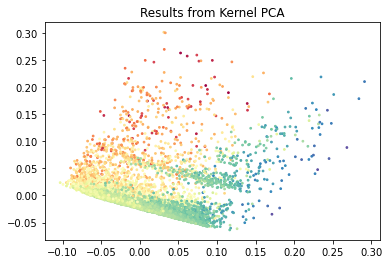

In [46]:
coluse = subinfo[FullModelRespUse]

plt.scatter(fittotrainset[:, 0], fittotrainset[:, 1], c=coluse[subinfo['Set']==0], cmap=plt.cm.Spectral,s=3)
plt.title("Results from Kernel PCA")

plt.show()

### Construct the Kernel training and test sets

Next we construct a training/test set that will be used in learning the relationship between the kernel function and the observable/unobservable pairs.

Not all pairs are chosen, as there would be too many, in general. The value of `numpairs` controls this.

In [47]:
numpairs = 20000

Choose out the pairs.

In [48]:
from itertools import combinations

allpairs = list(combinations(range(Xmat.shape[0]), 2))
samppairs = random.sample(allpairs,numpairs)

The matrix `KernModTrainTest` holds the data used to train and test the kernel function model.

Each row of `KernModTrainTest` holds one pair.

The first column of `KernModTrainTest` is the "reponse," i.e., the kernel function evaluated between the two observations in the pair.

The next set of columns holds the **observable** variables from the first galaxy in the pair.

The next set of columns holds the **observable and unobservable** variables from the second galaxy in the pair.

The final column is the inner product between the observable variables between the two variables in the pair. Keep in mind that the inner product is a key ingredient in the calculation of the sigmoid kernel. It has been found that including this as one of the available predictors improves the performance of the model.

In [49]:
pos = 0
br1 = len(ObsPredsUse)+1
br2 = br1 + len(PredsFullModel)

KernModTrainTest = np.zeros((numpairs,br2+1))

for pr in samppairs:
    KernModTrainTest[pos,0] = KmatTrans[pr]
    KernModTrainTest[pos,1:br1] = Set0.iloc[pr[0]][ObsPredsUse]
    KernModTrainTest[pos,br1:br2] = Set0.iloc[pr[1]][PredsFullModel]
    KernModTrainTest[pos,br2] = sum(Set0.iloc[pr[0]][ObsPredsUse] * Set0.iloc[pr[1]][ObsPredsUse])

    pos +=1

### Fit Neural Network for Kernel function

Use the set built above to fit the neural network for predicting the kernel function.

Tuning parameters

In [50]:
learning_rate = 0.0001
momentum = 0.8
bsize = 128
numepochs = 500
dropoutrate = 0.50
decay_rate = learning_rate / numepochs

Split into train and test sets.

In [51]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = \
   train_test_split(KernModTrainTest[:,1:], KernModTrainTest[:,0], 
        test_size = 0.2, random_state = 0)

Set up functions.

In [52]:
from tensorflow.keras import models, layers, utils, backend as K
from tensorflow.random import set_seed

set_seed(0)

Set up model architecture.

In [53]:
n_features = train_features.shape[1]


model = models.Sequential(name="SimpleNN", layers=[
    ### hidden layer 1
    layers.Dense(name="h1", input_dim=n_features,
                 units=6000, 
                 activation='relu'),
    
    layers.Dropout(name="drop1", rate=dropoutrate, seed=globalseed),
    
    ### hidden layer 2
    layers.Dense(name="h2", units=4000, 
                 activation='relu'),
    
    layers.Dropout(name="drop2", rate=dropoutrate, seed=globalseed+1),
    
    ### hidden layer 3
    #layers.Dense(name="h3", units=400, 
    #            activation='relu'),
    
    #layers.Dropout(name="drop3", rate=dropoutrate, seed=globalseed+2),
    
    ### hidden layer 4
    #layers.Dense(name="h4", units=400, 
    #            activation='relu'),
    
    #layers.Dropout(name="drop4", rate=dropoutrate, seed=globalseed+3),
    
    ### layer output
    layers.Dense(name="output", units=1, activation='linear')
])
model.summary()

Model: "SimpleNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
h1 (Dense)                   (None, 6000)              132000    
_________________________________________________________________
drop1 (Dropout)              (None, 6000)              0         
_________________________________________________________________
h2 (Dense)                   (None, 4000)              24004000  
_________________________________________________________________
drop2 (Dropout)              (None, 4000)              0         
_________________________________________________________________
output (Dense)               (None, 1)                 4001      
Total params: 24,140,001
Trainable params: 24,140,001
Non-trainable params: 0
_________________________________________________________________


Define the metric to be used.

In [54]:
def R2(y, y_hat):
    ss_res =  K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

Compile the model and output some of the tuning parameters.

In [55]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model.compile(optimizer=sgd, loss='mean_squared_error', metrics=[R2])

print("\n----------------------------------------------------")
print("Number of epochs:",numepochs)
print("learning rate:",learning_rate)
print("decay rate:",decay_rate)
print("momentum:",momentum)
print("dropout rate:",dropoutrate)
print("batch size:",bsize)


----------------------------------------------------
Number of epochs: 500
learning rate: 0.0001
decay rate: 2.0000000000000002e-07
momentum: 0.8
dropout rate: 0.5
batch size: 128


The scale of the kernel function can be quite small. It was found that adjusting it helped with the training. The response is multiplied by `fitscale` prior to training.

In [56]:
fitscale = 1000
train_labels = train_labels*fitscale

Train the model

In [ ]:
training = model.fit(x=train_features, y=train_labels, 
     batch_size=bsize, epochs=numepochs, shuffle=True, verbose=2,
    validation_split=0.3)

Epoch 1/500
88/88 - 5s - loss: 6.0037 - R2: 0.4878 - val_loss: 2.5542 - val_R2: 0.7602
Epoch 2/500
88/88 - 5s - loss: 2.4174 - R2: 0.7874 - val_loss: 2.3947 - val_R2: 0.7636
Epoch 3/500
88/88 - 5s - loss: 2.1614 - R2: 0.7963 - val_loss: 2.3794 - val_R2: 0.7632
Epoch 4/500
88/88 - 5s - loss: 2.0555 - R2: 0.8078 - val_loss: 2.3624 - val_R2: 0.7632
Epoch 5/500
88/88 - 5s - loss: 2.0320 - R2: 0.8038 - val_loss: 2.3259 - val_R2: 0.7665
Epoch 6/500
88/88 - 5s - loss: 2.0257 - R2: 0.8099 - val_loss: 2.3234 - val_R2: 0.7655
Epoch 7/500
88/88 - 5s - loss: 1.9881 - R2: 0.8083 - val_loss: 2.2690 - val_R2: 0.7712
Epoch 8/500
88/88 - 5s - loss: 1.9390 - R2: 0.8153 - val_loss: 2.2817 - val_R2: 0.7688
Epoch 9/500


Fitted values on both training and test sets.

In [ ]:
NNfitsontest = np.reshape(model.predict(test_features),-1)
NNfitsontrain = np.reshape(model.predict(train_features),-1)

The RMSE on the training and test sets.

In [ ]:
print("RMSE on training set:",round(sqrt(mean((NNfitsontrain-train_labels)**2)),5))
print("RMSE on test set:",round(sqrt(mean((NNfitsontest-test_labels*fitscale)**2)),5))

Plots showing performance of model, comparing fitted values with actual response, on both training and test sets.

In [ ]:
plt.figure(figsize=[5,5])
hist2d(x=NNfitsontrain,
       y=train_labels,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Neural Network Performance')
plt.ylabel('Training Set Response',size=12)
plt.xlabel('Training Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
#plt.xlim(-1.5,3)
#plt.ylim(-1.5,3)
plt.show()

plt.figure(figsize=[5,5])
hist2d(x=NNfitsontest,
       y=test_labels*fitscale,
         bins=200,
         norm=matplotlib.colors.LogNorm())
plt.title('Neural Network Performance')
plt.ylabel('Test Set Response',size=12)
plt.xlabel('Test Set Fitted Values',size=12)
plt.plot([-100, 100], [-100, 100], 'b-')
#plt.xlim(-1.5,3)
#plt.ylim(-1.5,3)

plt.show()

These plots show how performance evolves over the epochs.

In [ ]:
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training

ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric) 
    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation

ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

## Predicting the Kernel Function

Here we use the neural network fit above to actually extend the kernel function to cases where in each pair one of the galaxies only has observable variables.

Set 1 consists of galaxies for which only observable variables are assumed known.

In [ ]:
Set1 = subinfo[subinfo['Set']==1][ObsPredsUse].copy()

Calculate the estimated kernel applied to pairs consisting of a single row of Set 1, and each row of the training set used when fitting the neural network.

For each row $i$ in Set 1, calculate the (estimated) kernel function evaluated between $i$ and all galaxies in Set 0, i.e., the training/test set for the neural network.

The final result in the matrix `estK`.

Note that calling the predict function is time consuming. The strategy here is to break the task into batches of size `gs`. On each iteration, a group of `gs` rows of Set 1 are processed.

In [ ]:
from tqdm import tqdm
import time

s1z = Set1.shape[0] # The number of observations in Set 1
gs = 10

estK = np.zeros((Xmat.shape[0],s1z))

pos = 0

# This takes a while
for i in tqdm(range(int(floor(s1z/gs)))):
    
    fulldf = pd.DataFrame()
    
    for j in range(gs):
        onerow = matmul(np.ones([Xmat.shape[0],1]),np.array(Set1.iloc[pos,:]).reshape(1,6))
        onerow = pd.DataFrame(onerow,index=Xmat.index, columns = Set1.columns)
        holddf = pd.concat([onerow, Xmat],axis=1)
        holddf['inprod'] = matmul(np.array(Xmat[ObsPredsUse]),np.array(Set1.iloc[pos,:]).reshape(6,1))
        fulldf = fulldf.append(holddf)
        pos +=1

    estK[:,(i*gs):((i+1)*gs)] = model.predict_on_batch(fulldf).reshape(Xmat.shape[0],gs,order='F')/fitscale

# Do the last group

gs = s1z-pos # Reset gs to number of remaining rows

if(gs > 0):
    fulldf = pd.DataFrame()
    
    for j in range(gs):
        onerow = matmul(np.ones([Xmat.shape[0],1]),np.array(Set1.iloc[pos,:]).reshape(1,6))
        onerow = pd.DataFrame(onerow,index=Xmat.index, columns = Set1.columns)
        holddf = pd.concat([onerow, Xmat],axis=1)
        holddf['inprod'] = matmul(np.array(Xmat[ObsPredsUse]),np.array(Set1.iloc[pos,:]).reshape(6,1))
        fulldf = fulldf.append(holddf)
        pos +=1

    estK[:,(s1z-gs):s1z] = model.predict_on_batch(fulldf).reshape(Xmat.shape[0],gs,order='F')/fitscale

#import pickle
#output = open('estK.pkl', 'wb')
#pickle.dump(estK, output)
#output.close()

# Find the coordinates in the new space.

foo = np.matmul(Kernel_pca.alphas_.T, estK)
newcoords = foo.T/sqrt(Kernel_pca.lambdas_)

# Add them into the data frame.

Set1.drop(columns=[x for x in Set1.columns if x.startswith('KPCA')],inplace=True, errors='ignore')

for i in range(newcoords.shape[1]):
    Set1['KPCA'+str(i)] = newcoords[:,i]
    
NEWpreds = [x for x in Set1.columns if x.startswith('KPCA')]

Do the same thing for Set 2, which will serve as a final test set.

In [ ]:
Set2 = subinfo[subinfo['Set']==2][ObsPredsUse].copy()

from tqdm import tqdm
import time

s1z = Set2.shape[0] # The number of observations in Set 2
gs = 10

estK = np.zeros((Xmat.shape[0],s1z))
#estK = np.zeros((Xmat.shape[0],10))

pos = 0

# This takes a while
for i in tqdm(range(int(floor(s1z/gs)))):
    
    fulldf = pd.DataFrame()
    
    for j in range(gs):
        onerow = matmul(np.ones([Xmat.shape[0],1]),np.array(Set2.iloc[pos,:]).reshape(1,6))
        onerow = pd.DataFrame(onerow,index=Xmat.index, columns = Set2.columns)
        holddf = pd.concat([onerow, Xmat],axis=1)
        holddf['inprod'] = matmul(np.array(Xmat[ObsPredsUse]),np.array(Set2.iloc[pos,:]).reshape(6,1))
        fulldf = fulldf.append(holddf)
        pos +=1

    estK[:,(i*gs):((i+1)*gs)] = model.predict_on_batch(fulldf).reshape(Xmat.shape[0],gs,order='F')/fitscale

# Do the last group

gs = s1z-pos # Reset gs to number of remaining rows

if(gs > 0):
    fulldf = pd.DataFrame()
    
    for j in range(gs):
        onerow = matmul(np.ones([Xmat.shape[0],1]),np.array(Set2.iloc[pos,:]).reshape(1,6))
        onerow = pd.DataFrame(onerow,index=Xmat.index, columns = Set2.columns)
        holddf = pd.concat([onerow, Xmat],axis=1)
        holddf['inprod'] = matmul(np.array(Xmat[ObsPredsUse]),np.array(Set2.iloc[pos,:]).reshape(6,1))
        fulldf = fulldf.append(holddf)
        pos +=1

    estK[:,(s1z-gs):s1z] = model.predict_on_batch(fulldf).reshape(Xmat.shape[0],gs,order='F')/fitscale

#import pickle
#output = open('estK.pkl', 'wb')
#pickle.dump(estK, output)
#output.close()

# Find the coordinates in the new space.

foo = np.matmul(Kernel_pca.alphas_.T, estK)
newcoords = foo.T/sqrt(Kernel_pca.lambdas_)

# Add them into the data frame.

Set2.drop(columns=[x for x in Set2.columns if x.startswith('KPCA')],inplace=True, errors='ignore')

for i in range(newcoords.shape[1]):
    Set2['KPCA'+str(i)] = newcoords[:,i]

Each of the new predictors is scaled to have mean zero and SD one. Note that the scaling is based only on the observations in Set 1, but applied to both Set 1 and Set 2.

In [ ]:
scaler = preprocessing.StandardScaler(copy=True)
scaler.fit(Set1[NEWpreds])
foo = pd.DataFrame(scaler.transform(Set1[NEWpreds]),columns=NEWpreds, index=Set1.index)
Set1 = pd.DataFrame.join(Set1.drop(NEWpreds,axis=1),foo)

foo = pd.DataFrame(scaler.transform(Set2[NEWpreds]),columns=NEWpreds, index=Set2.index)
Set2 = pd.DataFrame.join(Set2.drop(NEWpreds,axis=1),foo)

In [ ]:
from scipy.stats import kurtosis

kurtosishold = numpy.zeros(len(NEWpreds))

This shows the distribution of each of the new predictors. Also, the kurtosis is calculated and displayed. Highly skewed predictors are problematic, and seem to be largely driven by outliers. Hence, among these, ones with large kurtosis are removed.

In [ ]:
pos = 0
for pred in NEWpreds:
    plt.figure(figsize=[5,5])
    hist(Set1[pred], bins=100)
    kurtosishold[pos] = kurtosis(Set1[pred])
    print(kurtosis(Set1[pred]))
    plt.xlabel(pred,size=12)
    plt.show()
    pos +=1

The full list of predictors is constructed.

In [ ]:
NEWpreds2 = list(np.array(NEWpreds)[kurtosishold<100]) + ObsPredsUse

print(NEWpreds2)

In [ ]:
train_features = Set1[NEWpreds2]
train_labels = subinfo[subinfo['Set']==1][FullModelRespUse]

train_pixels = subinfo[subinfo['Set']==1]['pixelnum'] 

train_features = train_features.astype(float)

test_features = Set2[NEWpreds2]
test_labels = subinfo[subinfo['Set']==2][FullModelRespUse] 
test_features = test_features.astype(float)

rtry = [4,6,8,10,12,14,16]

FullPPR(train_features, train_labels, test_features, test_labels,
            train_pixels, rtry, runname='OrigModel',PredsNames=NEWpreds2,degtry=[2])

In [ ]:
train_features = Set1[ObsPredsUse]
train_labels = subinfo[subinfo['Set']==1][FullModelRespUse] 

train_pixels = subinfo[subinfo['Set']==1]['pixelnum'] 

train_features = train_features.astype(float)

test_features = Set2[ObsPredsUse]
test_labels = subinfo[subinfo['Set']==2][FullModelRespUse] 
test_features = test_features.astype(float)

rtry = [2,4,6,8,10,12,14]

FullPPR(train_features, train_labels, test_features, test_labels,
            train_pixels, rtry, runname='OrigModel',PredsNames=ObsPredsUse,degtry=[3])